<a href="https://colab.research.google.com/github/Omiros-Loupis/Finance-Tracker/blob/main/RegressionProblemDiabetesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Range of BMI: 18.0 - 42.2
No NaNs found.


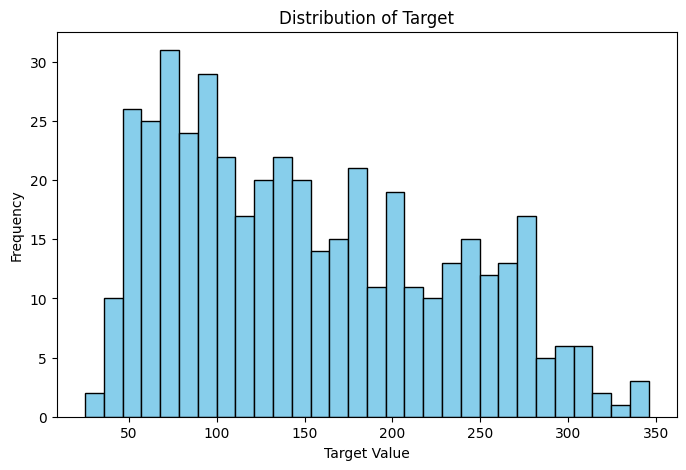

Starting Cross-Validation Loop...

Processing Model: RandomForest
  Generating SHAP plots for RandomForest...

Processing Model: GaussianProcess
  Generating SHAP plots for GaussianProcess...


  0%|          | 0/74 [00:00<?, ?it/s]


Processing Model: SVR
  Generating SHAP plots for SVR...


  0%|          | 0/74 [00:00<?, ?it/s]


Processing Model: GradientBoosting
  Generating SHAP plots for GradientBoosting...

--- Process Complete ---
Results saved to 'diabetes_regression_full_results.csv'


In [9]:
# ---  INSTALL & IMPORTS ---
# !pip install shap scikit-learn pandas matplotlib numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import os
import warnings
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.svm import SVR

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Create folder for plots
if not os.path.exists('plots'):
    os.makedirs('plots')

# ---  CONFIGURATION & LOADING ---
#  Define a fixed seed
SEED = 42
np.random.seed(SEED)

#  Load diabetes dataset
diabetes_data = load_diabetes(as_frame=True, scaled=False)
df = diabetes_data['frame']

#  Print range for one column
print(f"Range of BMI: {df['bmi'].min()} - {df['bmi'].max()}")

#  Check for NaNs and drop them
if df.isnull().values.any():
    print("NaNs found. Dropping...")
    df.dropna(inplace=True)
else:
    print("No NaNs found.")

X = df.drop(columns='target')
y = df['target']

#  Plot histogram for 'target' column
plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Target')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.savefig('plots/target_histogram.png')
plt.show()

# --- HELPER FUNCTION  ---
def get_metrics(y_true, y_pred):
    """Calculates RMSE, MAE, Max Error, and MAPE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    max_err = max_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) # 4th metric
    return max_err, rmse, mae, mape

# ---  SETUP MODELS & STORAGE ---
#  Create list to store data
csv_data = []
# Append header row
csv_data.append(["Model", "Set", "Fold",
                 "Max_n", "RMSE_n", "MAE_n", "MAPE_n",
                 "Max", "RMSE", "MAE", "MAPE"])

# Define models (RandomForest & GaussianProcess are required)
models_config = [
    ('RandomForest', RandomForestRegressor(random_state=SEED), {
        'n_estimators': [50, 100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    }),
    ('GaussianProcess', GaussianProcessRegressor(random_state=SEED, normalize_y=False), {
        'kernel': [1.0 * RBF(1.0) + WhiteKernel(1.0)],
        'alpha': [1e-10]
    }),
    ('SVR', SVR(), {
        'C': [1, 10],
        'kernel': ['rbf', 'linear']
    }),
    ('GradientBoosting', GradientBoostingRegressor(random_state=SEED), {
        'n_estimators': [50, 100],
        'learning_rate': [0.1],
        'max_depth': [3, 5]
    })
]

#  Split data into 6 folds using KFold
kf = KFold(n_splits=6, shuffle=True, random_state=SEED)

# ---  MAIN TRAINING LOOP ---
print("Starting Cross-Validation Loop...")

for name, model, params in models_config:
    print(f"\nProcessing Model: {name}")
    fold = 0

    # Loop based on kfold setup
    for train_index, test_index in kf.split(X):
        fold += 1

        # Get indices for this fold
        X_train_raw, X_test_raw = X.iloc[train_index], X.iloc[test_index]
        y_train_raw, y_test_raw = y.iloc[train_index], y.iloc[test_index]

        #  Normalize data (Min-Max)
        # We fit on Train and transform Test to avoid data leakage
        scaler_x = MinMaxScaler()
        X_train = scaler_x.fit_transform(X_train_raw)
        X_test = scaler_x.transform(X_test_raw)

        scaler_y = MinMaxScaler()
        # Reshape is needed for the scaler
        y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
        y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel()

        #  Train model using RandomizedSearchCV
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=3, # Low iter for speed
            cv=3,
            scoring='neg_mean_squared_error',
            random_state=SEED,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        #  Predict on train and test
        pred_train_n = best_model.predict(X_train)
        pred_test_n = best_model.predict(X_test)

        #  Denormalize predictions
        pred_train_real = scaler_y.inverse_transform(pred_train_n.reshape(-1, 1)).ravel()
        pred_test_real = scaler_y.inverse_transform(pred_test_n.reshape(-1, 1)).ravel()
        y_train_real = y_train_raw.values
        y_test_real = y_test_raw.values

        #  Calculate error metrics
        # Normalized metrics
        m_train_n = get_metrics(y_train, pred_train_n)
        m_test_n = get_metrics(y_test, pred_test_n)
        # Real metrics
        m_train_real = get_metrics(y_train_real, pred_train_real)
        m_test_real = get_metrics(y_test_real, pred_test_real)

        #  Append results to csv_data
        csv_data.append([name, "Train", fold, *m_train_n, *m_train_real])
        csv_data.append([name, "Test", fold, *m_test_n, *m_test_real])

        #  Plot Actual vs Predicted
        plt.figure(figsize=(5, 5))
        plt.scatter(y_test_real, pred_test_real, alpha=0.6, color='royalblue')
        # Ideal line
        plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', label='Ideal')
        plt.title(f'{name} (Fold {fold}) - Actual vs Predicted')
        plt.xlabel('Actual Output')
        plt.ylabel('Predicted Output')
        plt.legend()
        plt.savefig(f'plots/{name}_Fold{fold}_Scatter.png')
        plt.close()

        #  SHAP Explainer (Summary + Waterfall)
        # We run this only for the first fold to save time, or use a try-block
        if fold == 1:
            print(f"  Generating SHAP plots for {name}...")
            try:
                # Select explainer based on model type
                if name in ['RandomForest', 'GradientBoosting']:
                    explainer = shap.TreeExplainer(best_model)
                    shap_values = explainer(X_test)
                else:
                    # Generic KernelExplainer for GPR/SVR (using summary background for speed)
                    explainer = shap.KernelExplainer(best_model.predict, X_train[:10])
                    shap_values = explainer(X_test)

                # Fix feature names for plotting
                shap_values.feature_names = list(X.columns)

                # Summary Plot
                plt.figure()
                shap.summary_plot(shap_values, X_test, show=False)
                plt.title(f'SHAP Summary - {name}')
                plt.savefig(f'plots/{name}_SHAP_Summary.png', bbox_inches='tight')
                plt.close()

                # Waterfall Plots (2 examples)
                for i in range(2):
                    plt.figure()
                    shap.plots.waterfall(shap_values[i], show=False)
                    plt.title(f'SHAP Waterfall - {name} - Sample {i}')
                    plt.savefig(f'plots/{name}_Waterfall_{i}.png', bbox_inches='tight')
                    plt.close()
            except Exception as e:
                print(f"SHAP Error: {e}")

print("\n--- Process Complete ---")

# --- SAVE RESULTS ---
# Convert list to DataFrame and save
results_df = pd.DataFrame(csv_data[1:], columns=csv_data[0])
results_df.to_csv('diabetes_regression_full_results.csv', index=False)
print("Results saved to 'diabetes_regression_full_results.csv'")

# Zip plots for download